In [2]:
#%% Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
from nets_predict.classes.hmm import HiddenMarkovModelClass
from nets_predict.classes.partial_correlation import PartialCorrelationClass
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

HMMClass = HiddenMarkovModelClass()
PartialCorrClass = PartialCorrelationClass()

/users/win-fmrib-analysis/psz102/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# set parameters for script
n_chunk = 10
n_ICs = 25
n_edge = int((n_ICs * (n_ICs - 1))/2)

In [29]:
# set project directories
proj_dir = '/gpfs3/well/win-fmrib-analysis/users/psz102/nets-predict/nets_predict'
load_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"

# decide which featured to examine
feature_prediction_dict = dict()
feature_prediction_dict['actual'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual_with_r2.npz")
#feature_prediction_dict['static'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_states_0_model_mean_True_with_r2.npz")
#feature_prediction_dict['static_pca'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_pca_states_0_model_mean_True_with_r2.npz")
feature_prediction_dict['static_connecting_edges'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_connecting_edges_states_0_model_mean_True_with_r2.npz")
#feature_prediction_dict['static_self_edge_only'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_self_edge_only_states_0_model_mean_True_with_r2.npz")
feature_prediction_dict['xgboost'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_connecting_edges_states_0_model_mean_True_with_r2_model_xgboost.npz")
#feature_prediction_dict['xgboost_static'] = np.load(f"{load_dir}/edge_prediction_all_nm_cov_pm_icov_chunks_{n_chunk}_features_used_static_states_0_model_mean_True_with_r2_model_xgboost.npz")


In [30]:
# note how many dynamic features are being used and print what they are
n_feat_type = len(feature_prediction_dict) 
print(n_feat_type)
print(*feature_prediction_dict)
# let's combine the prediction accuracies for each hmm features into a combined array
hmm_features_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
hmm_features_r2_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
# hmm_features_mse_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
feat_num = 0
labels = []
for key, feature in feature_prediction_dict.items():
    print(feature)
    hmm_features_accuracy[feat_num,:,:] = feature['accuracy_per_edge']
    hmm_features_r2_accuracy[feat_num,:,:] = feature['r2_accuracy_per_edge']
    labels.append(key) # create labels for plot
    
    feat_num += 1

3
actual static_connecting_edges xgboost


In [33]:
# if n_chunk==12:
# labels[0] = 'Static (as-is)'
# labels[1] = 'Static (all edges)'
# labels[2] = 'Static (self edge + \n pca on other edges)'
# labels[3] = 'Static (connecting edges)'
# labels[4] = 'Static (self edge only)'
# labels[5] = 'xgboost'


labels[0] = 'Static (as-is)'
labels[1] = 'Static (connecting edges)'
labels[2] = 'xgboost'
#labels[3] = 'xgboost (static cov)'

/tmp/ipykernel_135600/1450359133.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
/tmp/ipykernel_135600/1450359133.py:33: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
/tmp/ipykernel_135600/1450359133.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([f'{label}\nMean: {mean_accuracy[label]:.4f}' for label in xticks], rotation=45, ha='right')
/tmp/ipykernel_135600/1450359133.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group

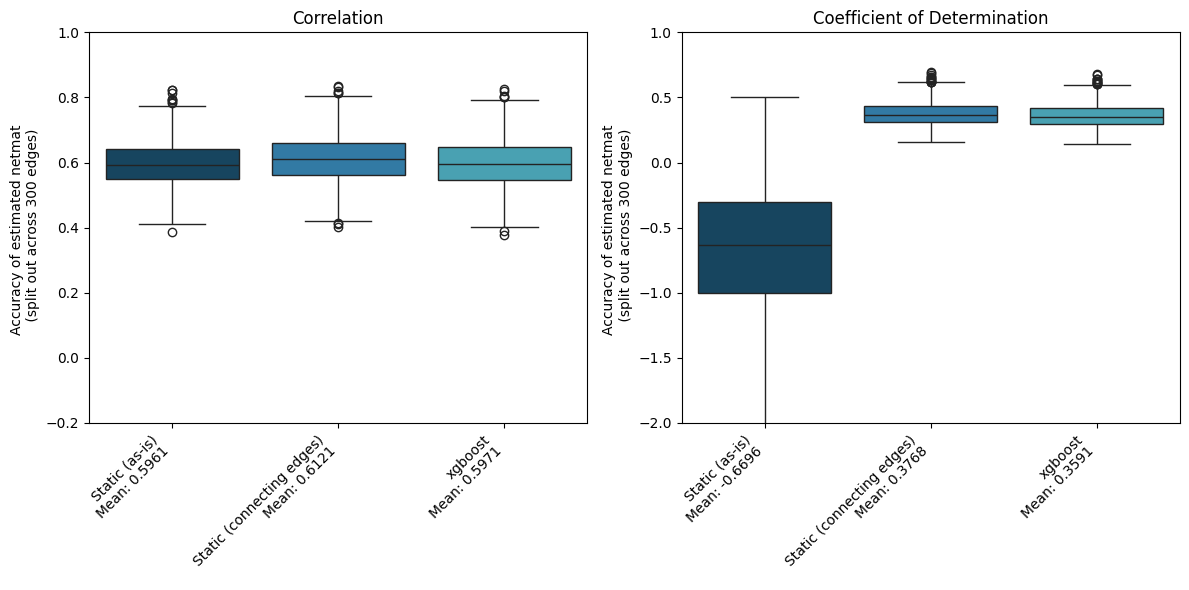

In [34]:
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd', '#9ad6b8', '#c8e9b3', '#e1f5ca']
ymin = -0.2  # Minimum y-value
ymax = 1  # Maximum y-value

# Assuming you have the same 'labels' and number of feature types
n_feat_type = len(labels)  # Replace with the correct number if different

# Convert hmm_features_r2_accuracy to list format
hmm_features_r2_accuracy_list = []
hmm_features_accuracy_list = []
for j in range(n_feat_type):
    hmm_features_r2_accuracy_list.append(hmm_features_r2_accuracy[j,:,:].flatten())
    hmm_features_accuracy_list.append(hmm_features_accuracy[j,:,:].flatten())

# Create a dataframe with the r2 data and group names
df_r2 = pd.DataFrame({
    'Group': np.repeat(labels, [hmm_features_r2_accuracy_list[i].shape[0] for i in range(len(labels))]),
    'Value': np.concatenate(hmm_features_r2_accuracy_list)
})

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for hmm_features_accuracy
df_accuracy = pd.DataFrame({
    'Group': np.repeat(labels, [hmm_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
    'Value': np.concatenate(hmm_features_accuracy_list)
})

mean_accuracy = df_accuracy.groupby('Group')['Value'].mean()
mean_r2 = df_r2.groupby('Group')['Value'].mean()

sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Accuracy of estimated netmat \n (split out across 300 edges)')
axes[0].set_ylim(ymin, ymax)
axes[0].set_title('Correlation', fontsize=12)
#axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
xticks = [label.get_text() for label in axes[0].get_xticklabels()]
axes[0].set_xticklabels([f'{label}\nMean: {mean_accuracy[label]:.4f}' for label in xticks], rotation=45, ha='right')


# Boxplot for hmm_features_r2_accuracy
sns.boxplot(x='Group', y='Value', data=df_r2, palette=colors, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Accuracy of estimated netmat \n (split out across 300 edges)')
axes[1].set_ylim(ymin, ymax)
axes[1].set_ylim(-2, ymax)
axes[1].set_title('Coefficient of Determination', fontsize=12)
#axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
xticks = [label.get_text() for label in axes[1].get_xticklabels()]
axes[1].set_xticklabels([f'{label}\nMean: {mean_r2[label]:.4f}' for label in xticks], rotation=45, ha='right')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

{'2 chunks (as-is) \n 30 mins': <numpy.lib.npyio.NpzFile object at 0x7f7bab20ffa0>, '2 chunks (prediction) \n 30 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae57d30>, '3 chunks (as-is) \n 20 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0d1a11b0>, '3 chunks (prediction) \n 20 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae980d0>, '4 chunks (as-is) \n 15 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae98130>, '4 chunks (prediction) \n 15 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae98250>, '5 chunks (as-is) \n 12 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae982b0>, '5 chunks (prediction) \n 12 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae983d0>, '6 chunks (as-is) \n 10 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae98430>, '6 chunks (prediction) \n 10 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae98550>, '10 chunks (as-is) \n 6 mins': <numpy.lib.npyio.NpzFile object at 0x7f7b0ae985b0>, '10 chunks (prediction) \n 6 mins': <numpy.lib.npyio.NpzFile 

/tmp/ipykernel_117470/864858488.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
/tmp/ipykernel_117470/864858488.py:61: UserWarning: 
The palette list has fewer values (7) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
/tmp/ipykernel_117470/864858488.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
/tmp/ipykernel_117470/864858488.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grou

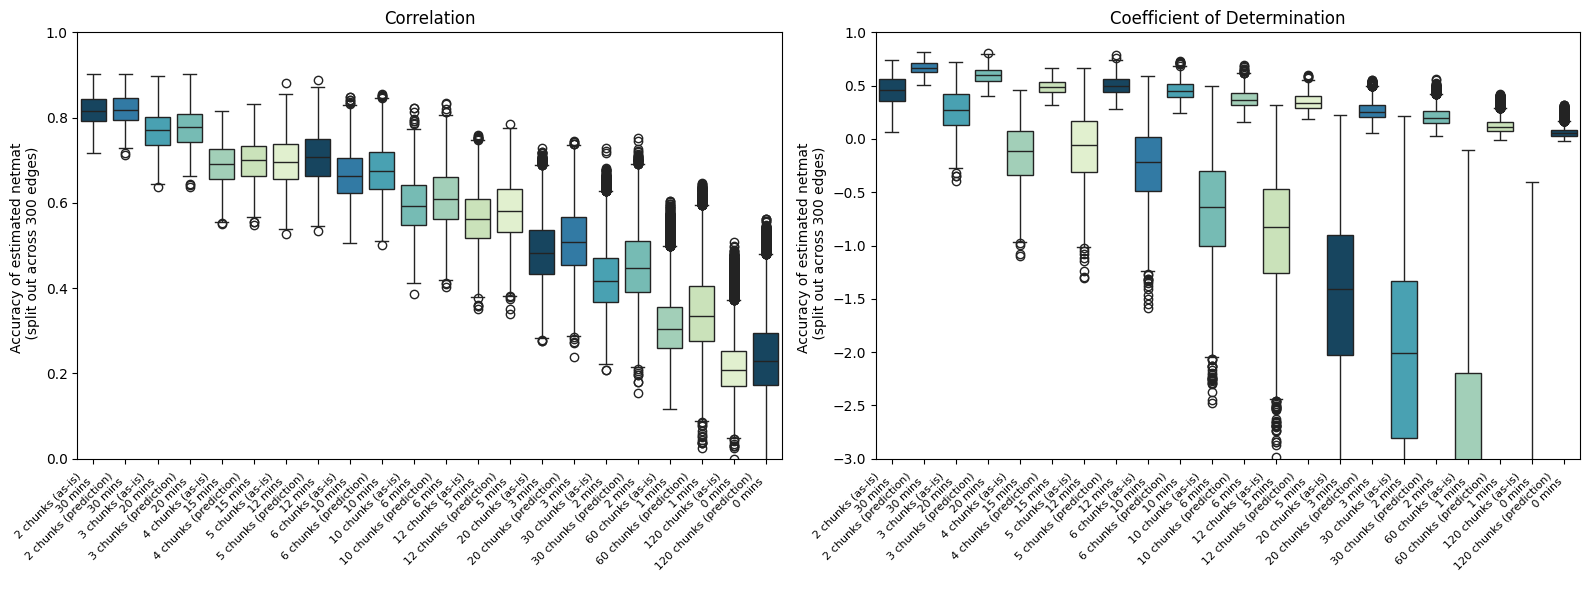

In [7]:
import re
#n_chunk_list = [2,3,4,5,6,10,12,15,20,30,60,120]
n_chunk_list = [2, 3, 4, 5, 6, 10, 12, 20, 30, 60, 120]

feature_prediction_chunk_dict = dict()

for n_chunk in n_chunk_list:
    chunk_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"
    feature_prediction_chunk_dict[f"{n_chunk} chunks (as-is) \n {int(60/n_chunk)} mins"] = np.load(f"{chunk_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
    feature_prediction_chunk_dict[f"{n_chunk} chunks (prediction) \n {int(60/n_chunk)} mins"] = np.load(f"{chunk_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_connecting_edges_states_0_model_mean_True_with_r2.npz")

print(feature_prediction_chunk_dict)

# note how many dynamic features are being used and print what they are
n_chunk_list = len(feature_prediction_chunk_dict) 

# let's combine the prediction accuracies for each hmm features into a combined array
chunk_features_accuracy = np.zeros((n_chunk_list, n_chunk, n_edge))
chunk_features_r2_accuracy = np.zeros((n_chunk_list, n_chunk, n_edge))
# hmm_features_mse_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
feat_num = 0
labels = []
for key, feature in feature_prediction_chunk_dict.items():
    #n_chunk_iter = int(key[0:3])
    n_chunk_iter = int(re.search('[0-9]+', key).group())
    #print(feature)
    #print(n_chunk_iter)
    chunk_features_accuracy[feat_num,0:n_chunk_iter,:] = feature['accuracy_per_edge']
    
    #chunk_features_r2_accuracy[feat_num,0:n_chunk_iter,:] = feature['r2_per_edge_nm_icov_pm_icov']
    chunk_features_r2_accuracy[feat_num,0:n_chunk_iter,:] = feature['r2_accuracy_per_edge']
    labels.append(key) # create labels for plot
    
    feat_num += 1

# Convert hmm_features_r2_accuracy to list format
chunk_features_r2_accuracy_list = []
chunk_features_accuracy_list = []
for j in range(n_chunk_list):
    r2_accuracies = chunk_features_r2_accuracy[j,:,:].flatten()
    accuracies = chunk_features_accuracy[j,:,:].flatten()

    chunk_features_r2_accuracy_list.append(r2_accuracies[r2_accuracies != 0])
    chunk_features_accuracy_list.append(accuracies[accuracies != 0])

# Create a dataframe with the r2 data and group names
df_r2 = pd.DataFrame({
    'Group': np.repeat(labels, [chunk_features_r2_accuracy_list[i].shape[0] for i in range(len(labels))]),
    'Value': np.concatenate(chunk_features_r2_accuracy_list)
})

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for hmm_features_accuracy
df_accuracy = pd.DataFrame({
    'Group': np.repeat(labels, [chunk_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
    'Value': np.concatenate(chunk_features_accuracy_list)
})

sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Accuracy of estimated netmat \n (split out across 300 edges)')
axes[0].set_ylim(0, ymax)
axes[0].set_title('Correlation', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)

# Boxplot for hmm_features_r2_accuracy
sns.boxplot(x='Group', y='Value', data=df_r2, palette=colors, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Accuracy of estimated netmat \n (split out across 300 edges)')
axes[1].set_ylim(ymin, ymax)
#axes[1].set_ylim(-10, ymax)
axes[1].set_ylim(-3, ymax)
axes[1].set_title('Coefficient of Determination', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

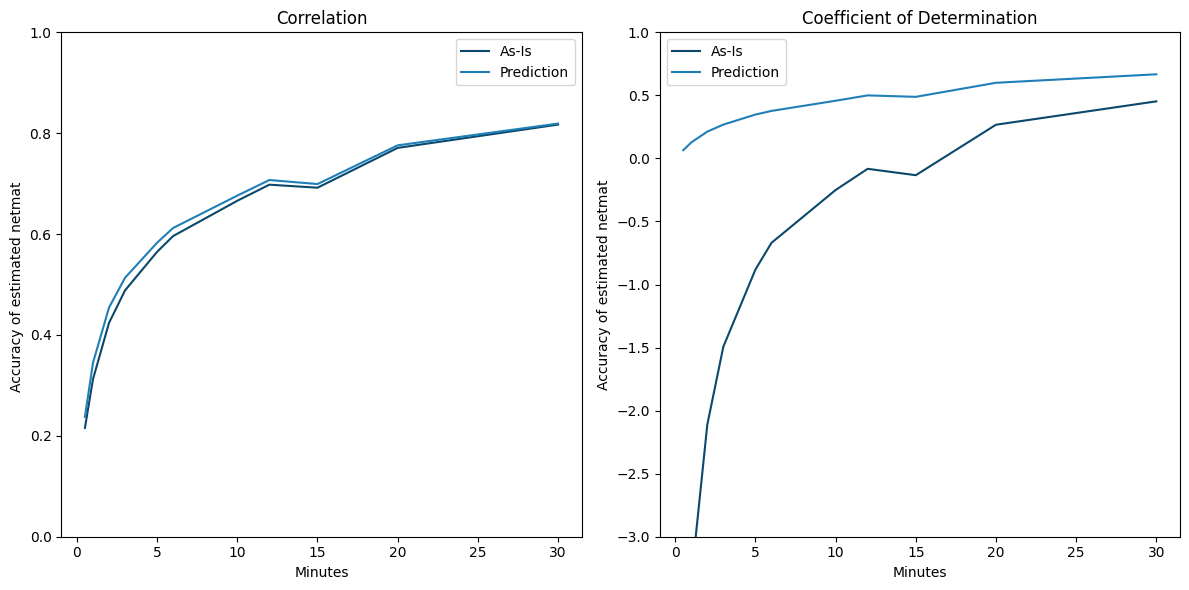

In [8]:
# Calculate means for each frequency
means_accuracy = {label: np.nanmean(np.ma.masked_equal(chunk_features_accuracy[i, :, :], 0)) for i, label in enumerate(labels)}
means_r2 = {label: np.nanmean(np.ma.masked_equal(chunk_features_r2_accuracy[i, :, :], 0)) for i, label in enumerate(labels)}

# Separate 'as-is' and 'prediction' labels and means
labels_as_is = [label for label in labels if 'as-is' in label]
labels_prediction = [label for label in labels if 'prediction' in label]

means_accuracy_as_is = [means_accuracy[label] for label in labels_as_is]
means_accuracy_prediction = [means_accuracy[label] for label in labels_prediction]
means_r2_as_is = [means_r2[label] for label in labels_as_is]
means_r2_prediction = [means_r2[label] for label in labels_prediction]

# Extract chunks from labels
chunks = [float(label.split()[0]) for label in labels_as_is]
minutes = [60 / chunk for chunk in chunks]

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Line plot for accuracy
axes[0].plot(minutes, means_accuracy_as_is, label='As-Is', color=colors[0])
axes[0].plot(minutes, means_accuracy_prediction, label='Prediction', color=colors[1])
axes[0].set_xlabel('Minutes')
axes[0].set_ylabel('Accuracy of estimated netmat ')
axes[0].set_ylim(0, ymax)
axes[0].set_title('Correlation')
axes[0].legend()

# Line plot for R2
axes[1].plot(minutes, means_r2_as_is, label='As-Is', color=colors[0])
axes[1].plot(minutes, means_r2_prediction, label='Prediction', color=colors[1])
axes[1].set_xlabel('Minutes')
axes[1].set_ylabel('Accuracy of estimated netmat')
axes[1].set_ylim(-3, ymax)
axes[1].set_title('Coefficient of Determination')
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/tmp/ipykernel_117470/4122020663.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
/tmp/ipykernel_117470/4122020663.py:68: UserWarning: 
The palette list has fewer values (7) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
/tmp/ipykernel_117470/4122020663.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_117470/4122020663.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='V

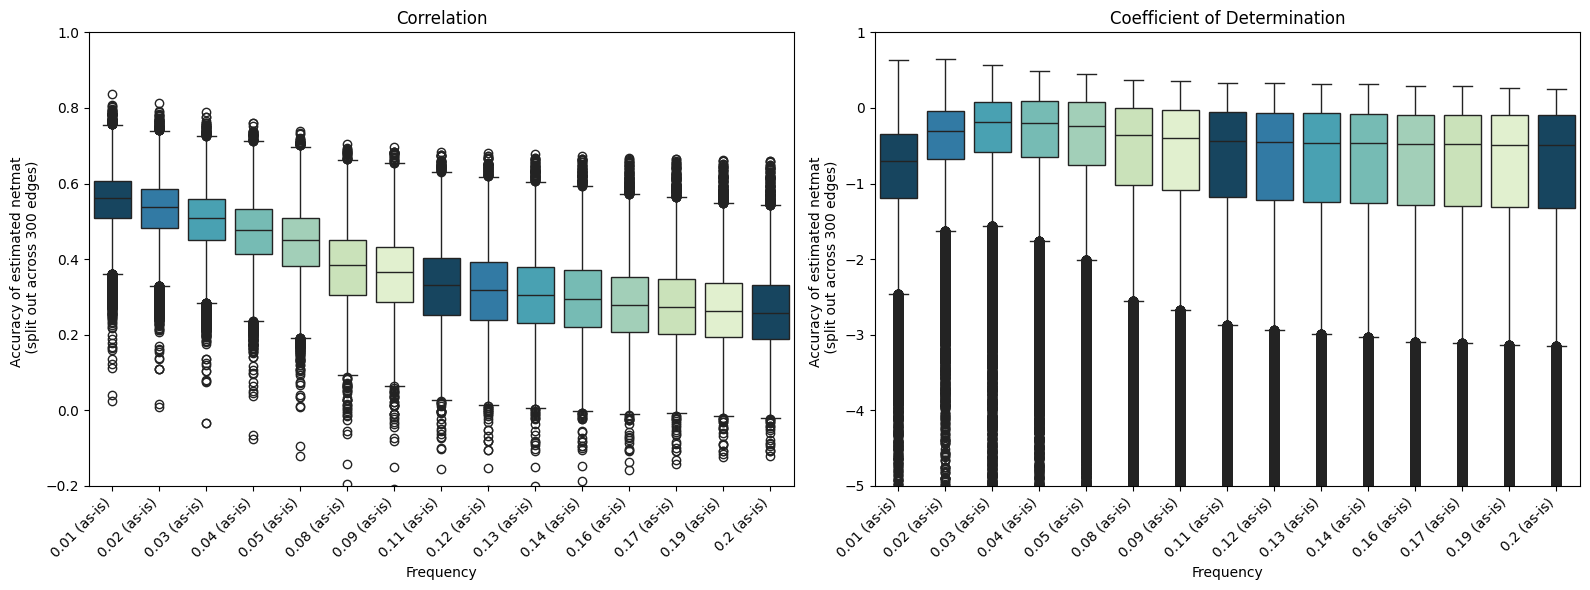

In [9]:

n_chunk = 12 # 4 #12
n_ICs = 100
n_edge = int((n_ICs * (n_ICs - 1))/2)

#freq_list = np.arange(0.01, 0.21, 0.01)
freq_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.09, 0.11, 0.12, 0.13, 0.14, 0.16, 0.17, 0.19, 0.20]

n_freq_list = len(freq_list)
feature_prediction_highpass_dict = dict()
chunk_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"

def replace_dots_with_underscores(value):
    return str(value).replace('.', '_')

for low_freq in freq_list:
    low_freq_str = replace_dots_with_underscores(f"{np.round(low_freq,3):02}")
    #print(low_freq_str)
    
    #file_path = f"{chunk_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual_low_freq_{low_freq_str}.npz"
    file_path = f"{chunk_dir}/edge_prediction_all_nm_cov_pm_cov_chunks_{n_chunk}_features_used_actual_low_freq_{low_freq_str}.npz"
    feature_prediction_highpass_dict[f"{np.round(low_freq,3):02} (as-is)"] = np.load(file_path)
    #file_path = f"{chunk_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_connecting_edges_states_0_model_mean_True_with_r2_low_freq_{low_freq_str}.npz"
    #feature_prediction_highpass_dict[f"{np.round(low_freq,3):02} prediction"] = np.load(file_path)

# let's combine the prediction accuracies for each hmm features into a combined array
n_freq_list = len(feature_prediction_highpass_dict) 
freq_features_accuracy = np.zeros((n_freq_list, n_chunk, n_edge))
freq_features_r2_accuracy = np.zeros((n_freq_list, n_chunk, n_edge))
feat_num = 0
labels = []
for key, feature in feature_prediction_highpass_dict.items():
    #print(feature)
    freq_features_accuracy[feat_num,:,:] = feature['accuracy_per_edge']
    #freq_features_r2_accuracy[feat_num,:,:] = feature['r2_per_edge_nm_icov_pm_icov']
    freq_features_r2_accuracy[feat_num,:,:] = feature['r2_accuracy_per_edge']
    #freq_features_r2_accuracy[feat_num,:,:] = feature['r2_per_edge_nm_cov_pm_cov']
    labels.append(key) # create labels for plot
    
    feat_num += 1



# Convert hmm_features_r2_accuracy to list format
freq_features_r2_accuracy_list = []
freq_features_accuracy_list = []
for j in range(n_freq_list):
    r2_accuracies = freq_features_r2_accuracy[j,:,:].flatten()
    accuracies = freq_features_accuracy[j,:,:].flatten()

    freq_features_r2_accuracy_list.append(r2_accuracies[r2_accuracies != 0])
    freq_features_accuracy_list.append(accuracies[accuracies != 0])

# Create a dataframe with the r2 data and group names
df_r2 = pd.DataFrame({
    'Group': np.repeat(labels, [freq_features_r2_accuracy_list[i].shape[0] for i in range(len(labels))]),
    'Value': np.concatenate(freq_features_r2_accuracy_list)
})

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for hmm_features_accuracy
df_accuracy = pd.DataFrame({
    'Group': np.repeat(labels, [freq_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
    'Value': np.concatenate(freq_features_accuracy_list)
})

sns.boxplot(x='Group', y='Value', data=df_accuracy, palette=colors, ax=axes[0])
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Accuracy of estimated netmat \n (split out across 300 edges)')
axes[0].set_ylim(ymin, ymax)
axes[0].set_title('Correlation', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Boxplot for hmm_features_r2_accuracy
sns.boxplot(x='Group', y='Value', data=df_r2, palette=colors, ax=axes[1])
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Accuracy of estimated netmat \n (split out across 300 edges)')
axes[1].set_ylim(ymin, ymax)
if n_ICs==100:
    axes[1].set_ylim(-5, ymax)
else:
    axes[1].set_ylim(-1, ymax)
axes[1].set_title('Coefficient of Determination', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

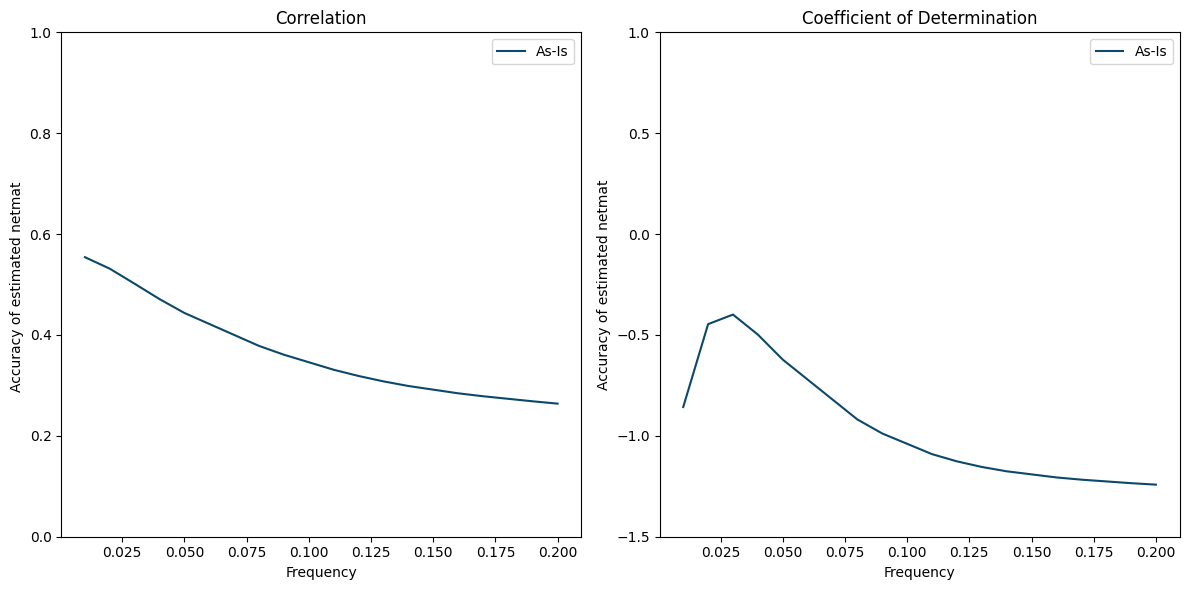

In [11]:
# Calculate means for each frequency
means_accuracy = {label: np.mean(freq_features_accuracy[i, :, :]) for i, label in enumerate(labels)}
means_r2 = {label: np.mean(freq_features_r2_accuracy[i, :, :]) for i, label in enumerate(labels)}

# Separate 'as-is' and 'prediction' labels and means
labels_as_is = [label for label in labels if 'as-is' in label]
labels_prediction = [label for label in labels if 'prediction' in label]

means_accuracy_as_is = [means_accuracy[label] for label in labels_as_is]
means_accuracy_prediction = [means_accuracy[label] for label in labels_prediction]
means_r2_as_is = [means_r2[label] for label in labels_as_is]
means_r2_prediction = [means_r2[label] for label in labels_prediction]

# Extract frequencies from labels
frequencies = [float(label.split()[0]) for label in labels_as_is]

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Line plot for accuracy
axes[0].plot(frequencies, means_accuracy_as_is, label='As-Is', color=colors[0])
#axes[0].plot(frequencies, means_accuracy_prediction, label='Prediction', color=colors[1])
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Accuracy of estimated netmat ')
axes[0].set_ylim(0, ymax)
axes[0].set_title('Correlation')
axes[0].legend()

# Line plot for R2
axes[1].plot(frequencies, means_r2_as_is, label='As-Is', color=colors[0])
#axes[1].plot(frequencies, means_r2_prediction, label='Prediction', color=colors[1])
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Accuracy of estimated netmat')
axes[1].set_ylim(-1.5, ymax)
axes[1].set_title('Coefficient of Determination')
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
#%% Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nets_predict.classes.hmm import HiddenMarkovModelClass
from nets_predict.classes.partial_correlation import PartialCorrelationClass
import pandas as pd

HMMClass = HiddenMarkovModelClass()
PartialCorrClass = PartialCorrelationClass()


In [ ]:
# set parameters for script
n_chunk = 4
n_ICs = 50
n_edge = int((n_ICs * (n_ICs - 1))/2)

In [ ]:
# set project directories
proj_dir = '/gpfs3/well/win-fmrib-analysis/users/psz102/nets-predict/nets_predict'
load_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"

# decide which featured to examine
feature_prediction_dict = dict()
feature_prediction_dict['static_icov_icov'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_states_0_model_mean_True.npz")
feature_prediction_dict['actual_icov_icov'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['actual_icov_cov'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_cov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['actual_cov_icov'] = np.load(f"{load_dir}/edge_prediction_all_nm_cov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['actual_cov_cov'] = np.load(f"{load_dir}/edge_prediction_all_nm_cov_pm_cov_chunks_{n_chunk}_features_used_actual.npz")


In [ ]:
# load ground truth matrix
ground_truth_dir = f"{proj_dir}/results/ICA_{n_ICs}/ground_truth"
ground_truth_matrix = np.load(f"{ground_truth_dir}/ground_truth_partial_mean_4_sessions.npy")

# extract upper diagonal (excluding main diagonal) 
ground_truth_icov_reshape = PartialCorrClass.extract_upper_off_main_diag(ground_truth_matrix)

# take mean ground truth across subjects
ground_truth_icov_reshape_mean = np.mean(ground_truth_icov_reshape,axis=0)


In [ ]:
print(*feature_prediction_dict['actual_icov_icov'])

accuracy_per_edge netmats_flatten


In [ ]:
print(*feature_prediction_dict['static_icov_icov'])
print(*feature_prediction_dict['actual_icov_icov'])
print(feature_prediction_dict['static_icov_icov']['predict_y'].shape) # prediction
print(feature_prediction_dict['actual_icov_icov']['netmats_flatten'].shape) # prediction
print(ground_truth_icov_reshape.shape) # target




alpha l1_ratio corr_y predict_y beta accuracy_per_edge
accuracy_per_edge netmats_flatten
(4, 1003, 1225)
(4, 1003, 1225)
(1003, 1225)


In [ ]:
# Get the shapes
prediction_shape = feature_prediction_dict['static_icov_icov']['predict_y'].shape
target_shape = ground_truth_icov_reshape.shape

# Initialize an array to store the MSE values
mse_values = np.zeros((prediction_shape[0], prediction_shape[2]))

# Iterate over each chunk
for i in range(prediction_shape[0]):
    # Calculate MSE for each target-prediction pair
    mse_values[i] = np.mean(np.square(ground_truth_icov_reshape - feature_prediction_dict['static_icov_icov']['predict_y'][i]), axis=0)

# Print the MSE values for each chunk
for i, mse_chunk in enumerate(mse_values):
    print(f"Chunk {i+1} MSE values:")
    print(mse_chunk)


Chunk 1 MSE values:
[0.84383759 0.68532267 0.48033135 ... 0.08059653 0.07037319 0.06501738]
Chunk 2 MSE values:
[0.88809172 0.67001854 0.51010053 ... 0.0805555  0.07255701 0.06879011]
Chunk 3 MSE values:
[0.77873011 0.73340716 0.49025139 ... 0.08295164 0.06665175 0.07225652]
Chunk 4 MSE values:
[0.77258836 0.73651671 0.50205943 ... 0.078887   0.07001817 0.06648482]


In [ ]:
n_chunk

4

In [ ]:
# Get the shapes for static_icov_icov and actual_icov_icov
prediction_shape_static = feature_prediction_dict['static_icov_icov']['predict_y'].shape
prediction_shape_actual = feature_prediction_dict['actual_icov_icov']['netmats_flatten'].shape

# Initialize arrays to store the MSE values
corr_values_static = np.zeros((prediction_shape_static[0], prediction_shape_static[2]))
corr_values_actual = np.zeros((prediction_shape_actual[0], prediction_shape_actual[2]))

# Calculate MSE values for static_icov_icov
for i in range(prediction_shape_static[0]):
    print(i)
    for j in range(prediction_shape_static[2]):
        corr_values_static[i, j] = np.corrcoef(ground_truth_icov_reshape[:, j], feature_prediction_dict['static_icov_icov']['predict_y'][i][:, j])[0,1]

# Calculate MSE values for actual_icov_icov
for i in range(prediction_shape_actual[0]):
    print(i)
    for j in range(prediction_shape_actual[2]):
        corr_values_actual[i, j] = np.corrcoef(ground_truth_icov_reshape[:, j], feature_prediction_dict['actual_icov_icov']['netmats_flatten'][i][:, j])[0,1]

0
1
2
3
0
1
2
3


/tmp/ipykernel_160852/2759075672.py:21: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(x='Group', y='MSE', hue='Dataset', data=df_combined_corr, palette=colors)


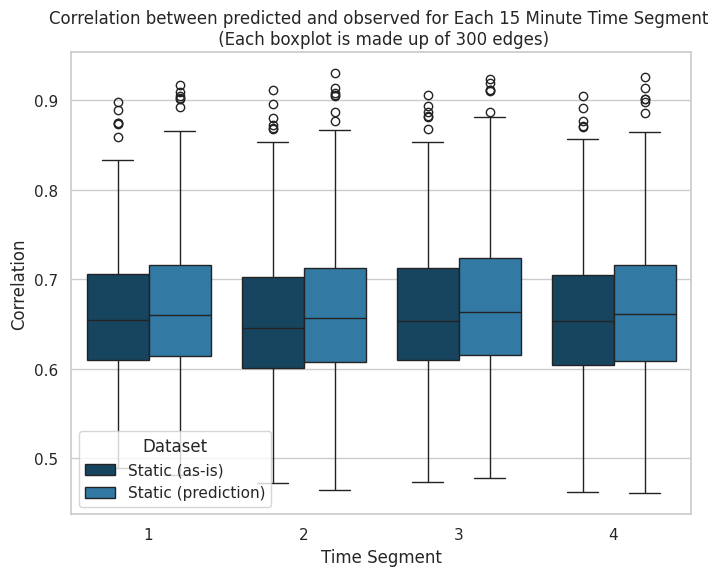

In [ ]:
# Create lists to hold MSE values for each chunk for both datasets
corr_values_list_static = [corr_values_static[i] for i in range(corr_values_static.shape[0])]
corr_values_list_actual = [corr_values_actual[i] for i in range(corr_values_actual.shape[0])]

# Create dataframes with the MSE data and group names for both datasets
df_corr_static = pd.DataFrame({'Group': np.repeat(range(1, n_chunk+1), corr_values_static.shape[1]),
                              'MSE': np.concatenate(corr_values_list_static),
                              'Dataset': 'Static (prediction)'})
df_corr_actual = pd.DataFrame({'Group': np.repeat(range(1, n_chunk+1), corr_values_actual.shape[1]),
                              'MSE': np.concatenate(corr_values_list_actual),
                              'Dataset': 'Static (as-is)'})

# Concatenate the dataframes for both datasets
df_combined_corr = pd.concat([df_corr_actual, df_corr_static], ignore_index=True)

# Set the colors for the boxplot
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd']

# Create the grouped boxplot using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='MSE', hue='Dataset', data=df_combined_corr, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('Time Segment')
plt.ylabel('Correlation')

# Set the title
plt.title("Correlation between predicted and observed for Each 15 Minute Time Segment \n (Each boxplot is made up of 300 edges)")

# Show the legend
plt.legend(title='Dataset')

# Show the plot
plt.show()

/tmp/ipykernel_160852/428026565.py:37: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(x='Group', y='MSE', hue='Dataset', data=df_combined_mse, palette=colors)


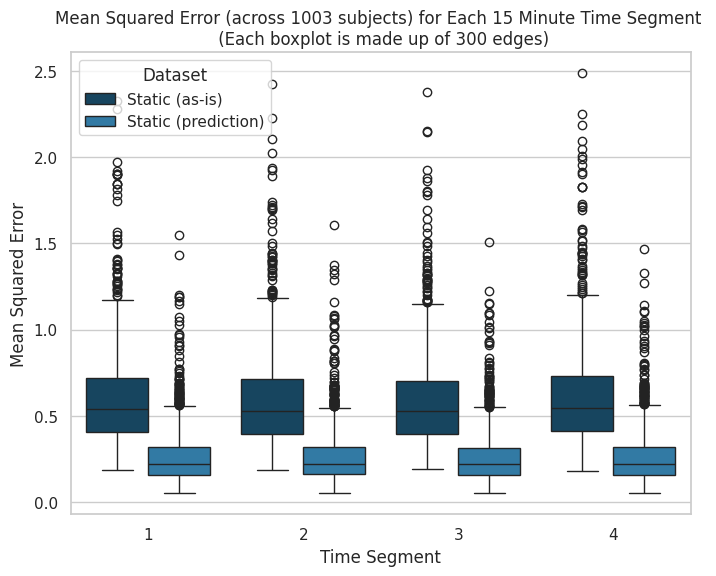

In [ ]:
# Get the shapes for static_icov_icov and actual_icov_icov
prediction_shape_static = feature_prediction_dict['static_icov_icov']['predict_y'].shape
prediction_shape_actual = feature_prediction_dict['actual_icov_icov']['netmats_flatten'].shape

# Initialize arrays to store the MSE values
mse_values_static = np.zeros((prediction_shape_static[0], prediction_shape_static[2]))
mse_values_actual = np.zeros((prediction_shape_actual[0], prediction_shape_actual[2]))

# Calculate MSE values for static_icov_icov
for i in range(prediction_shape_static[0]):
    mse_values_static[i] = np.mean(np.square(ground_truth_icov_reshape - feature_prediction_dict['static_icov_icov']['predict_y'][i]), axis=0)

# Calculate MSE values for actual_icov_icov
for i in range(prediction_shape_actual[0]):
    mse_values_actual[i] = np.mean(np.square(ground_truth_icov_reshape - feature_prediction_dict['actual_icov_icov']['netmats_flatten'][i]), axis=0)

# Create lists to hold MSE values for each chunk for both datasets
mse_values_list_static = [mse_values_static[i] for i in range(mse_values_static.shape[0])]
mse_values_list_actual = [mse_values_actual[i] for i in range(mse_values_actual.shape[0])]

# Create dataframes with the MSE data and group names for both datasets
df_mse_static = pd.DataFrame({'Group': np.repeat(range(1, n_chunk+1), mse_values_static.shape[1]),
                              'MSE': np.concatenate(mse_values_list_static),
                              'Dataset': 'Static (prediction)'})
df_mse_actual = pd.DataFrame({'Group': np.repeat(range(1, n_chunk+1), mse_values_actual.shape[1]),
                              'MSE': np.concatenate(mse_values_list_actual),
                              'Dataset': 'Static (as-is)'})

# Concatenate the dataframes for both datasets
df_combined_mse = pd.concat([df_mse_actual, df_mse_static], ignore_index=True)

# Set the colors for the boxplot
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd']

# Create the grouped boxplot using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='MSE', hue='Dataset', data=df_combined_mse, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('Time Segment')
plt.ylabel('Mean Squared Error')

# Set the title
plt.title("Mean Squared Error (across 1003 subjects) for Each 15 Minute Time Segment \n (Each boxplot is made up of 300 edges)")

# Show the legend
plt.legend(title='Dataset')

# Show the plot
plt.show()


In [ ]:
# Get the shapes for static_icov_icov and actual_icov_icov
prediction_shape_static = feature_prediction_dict['static_icov_icov']['predict_y'].shape
prediction_shape_actual = feature_prediction_dict['actual_icov_icov']['netmats_flatten'].shape

# Initialize arrays to store the MSE values
mse_values_static = np.zeros((prediction_shape_static[0], prediction_shape_static[2]))
mse_values_actual = np.zeros((prediction_shape_actual[0], prediction_shape_actual[2]))

# Calculate MSE values for static_icov_icov
for i in range(prediction_shape_static[0]):
    mse_values_static[i] = np.mean(np.square(ground_truth_icov_reshape - feature_prediction_dict['static_icov_icov']['predict_y'][i]), axis=0)

# Calculate MSE values for actual_icov_icov
for i in range(prediction_shape_actual[0]):
    mse_values_actual[i] = np.mean(np.square(ground_truth_icov_reshape - feature_prediction_dict['actual_icov_icov']['netmats_flatten'][i]), axis=0)

# Create lists to hold MSE values for each chunk for both datasets
mse_values_list_static = [mse_values_static[i] for i in range(mse_values_static.shape[0])]
mse_values_list_actual = [mse_values_actual[i] for i in range(mse_values_actual.shape[0])]

# Calculate the mean MSE values across 300 values for each chunk
mean_mse_static = np.mean(mse_values_static, axis=1)
mean_mse_actual = np.mean(mse_values_actual, axis=1)

# Create a dataframe with the mean MSE data and group names for both datasets
df_mean_mse_static = pd.DataFrame({'Chunk': range(1, n_chunk+1), 'Mean MSE': mean_mse_static, 'Netmats': 'Static (prediction)'})
df_mean_mse_actual = pd.DataFrame({'Chunk': range(1, n_chunk+1), 'Mean MSE': mean_mse_actual, 'Netmats': 'Static (as-is)'})

# Concatenate the dataframes for both datasets
df_combined_mean_mse = pd.concat([df_mean_mse_actual, df_mean_mse_static], ignore_index=True)


In [ ]:
# Calculate the mean correlation values across 300 values for each chunk
mean_correlation_static = np.mean(corr_values_static, axis=1)
mean_correlation_actual = np.mean(corr_values_actual, axis=1) 

# Create dataframes with the mean correlation data and group names for both datasets
df_mean_correlation_static = pd.DataFrame({'Chunk': range(1, n_chunk+1), 'Mean Correlation': mean_correlation_static, 'Netmats': 'Static (prediction)'})
df_mean_correlation_actual = pd.DataFrame({'Chunk': range(1, n_chunk+1), 'Mean Correlation': mean_correlation_actual, 'Netmats': 'Static (as-is)'})

# Concatenate the dataframes for both datasets
df_combined_mean_correlation = pd.concat([df_mean_correlation_actual, df_mean_correlation_static])


In [ ]:
print(df_combined_mean_correlation)



   Chunk  Mean Correlation              Netmats
0      1          0.658674       Static (as-is)
1      2          0.651079       Static (as-is)
2      3          0.660801       Static (as-is)
3      4          0.657411       Static (as-is)
0      1          0.665878  Static (prediction)
1      2          0.659801  Static (prediction)
2      3          0.668770  Static (prediction)
3      4          0.664574  Static (prediction)


/tmp/ipykernel_160852/3613658706.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('twilight_shifted')


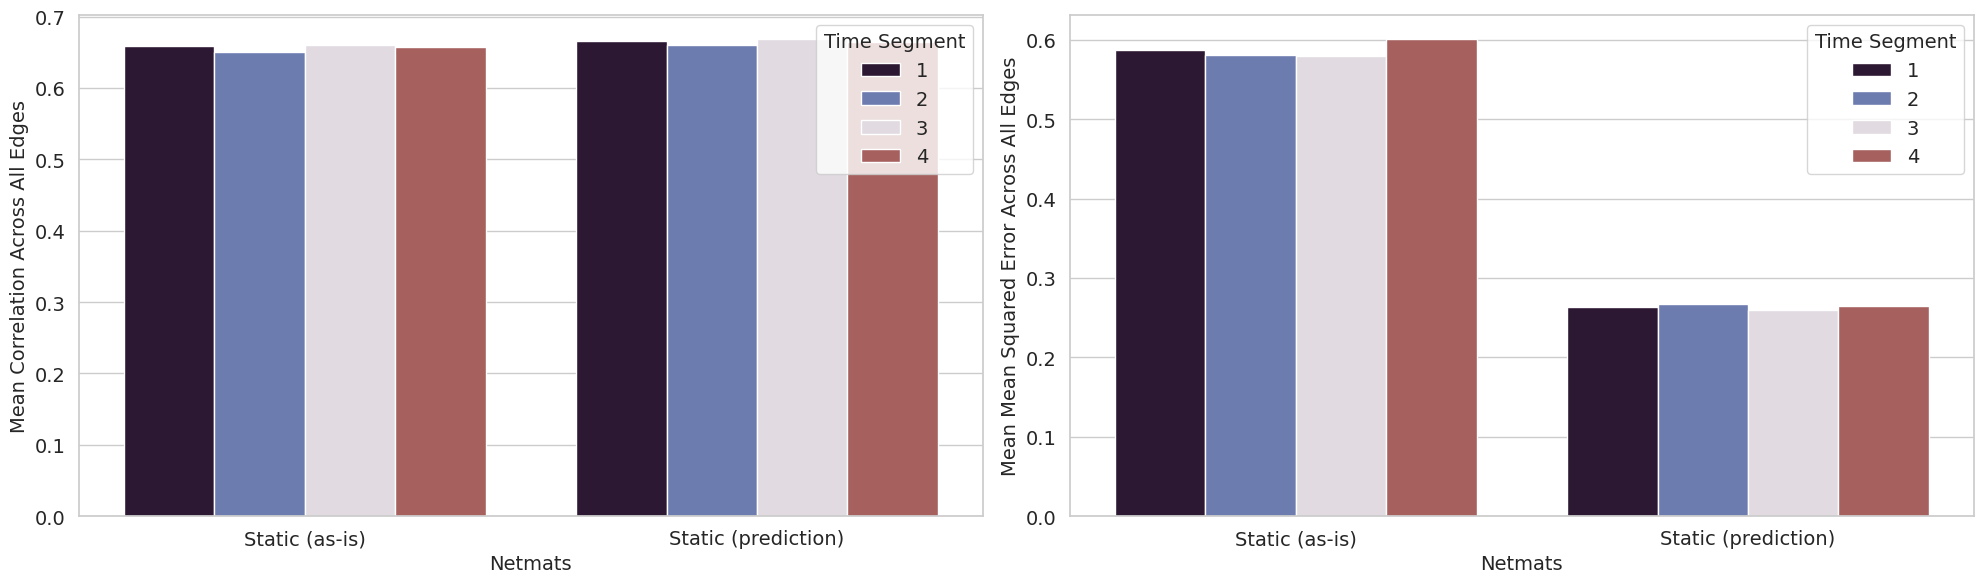

In [ ]:
# Set the colors for the bar chart
cmap = plt.cm.get_cmap('twilight_shifted')
colors = [cmap(i / n_chunk) for i in range(n_chunk)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot Mean Correlation
sns.barplot(x='Netmats', y='Mean Correlation', hue='Chunk', data=df_combined_mean_correlation, palette=colors, ax=axes[0])
axes[0].set_xlabel('Netmats', fontsize=14)
axes[0].set_ylabel('Mean Correlation Across All Edges', fontsize=14)
#axes[0].set_title('Mean Correlation between Predicted and Observed for Each Chunk', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(title='Time Segment', fontsize=14, title_fontsize=14)

# Plot Mean Squared Error
sns.barplot(x='Netmats', y='Mean MSE', hue='Chunk', data=df_combined_mean_mse, palette=colors, ax=axes[1])
axes[1].set_xlabel('Netmats', fontsize=14)
axes[1].set_ylabel('Mean Mean Squared Error Across All Edges', fontsize=14)
#axes[1].set_title('Mean Squared Error for Each Chunk', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(title='Time Segment', fontsize=14, title_fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

5
static_icov_icov actual_icov_icov actual_icov_cov actual_cov_icov actual_cov_cov
alpha l1_ratio corr_y predict_y beta accuracy_per_edge


/tmp/ipykernel_160852/3531178026.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('twilight_shifted')


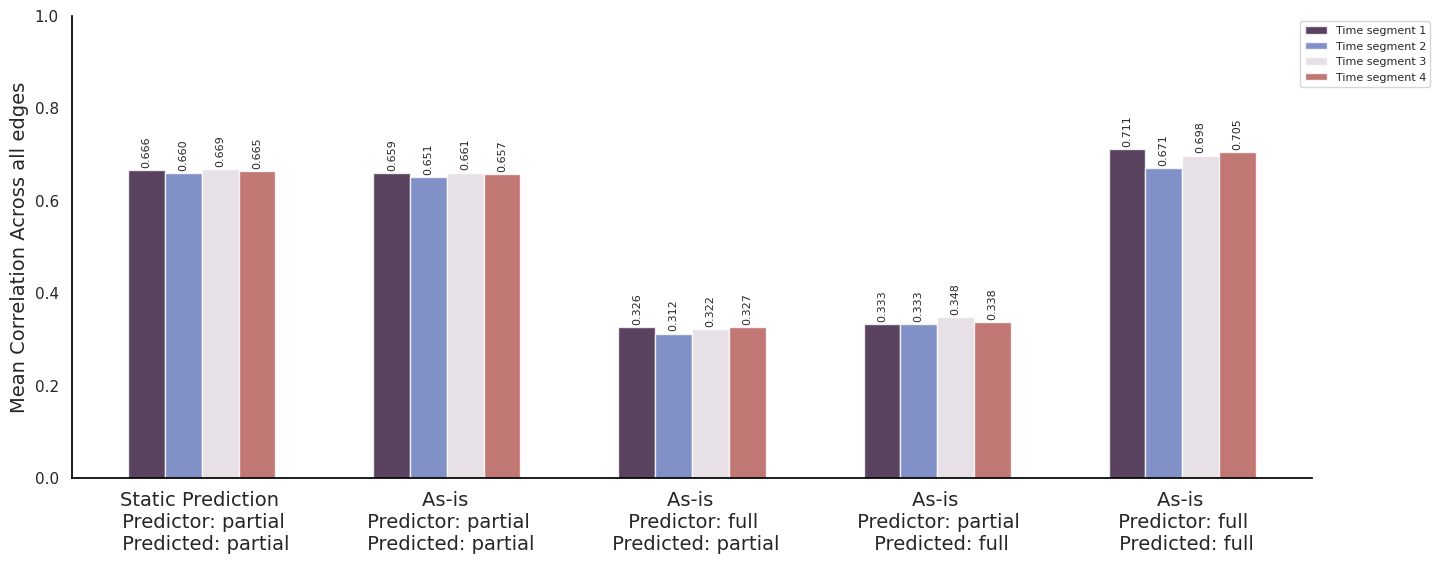

In [62]:
###################### let's compare partial correlations with full covariances (predictOR and predictED) ######################

# note how many dynamic features are being used and print what they are
n_feat_type = len(feature_prediction_dict) 
print(n_feat_type)
print(*feature_prediction_dict)

# let's combine the prediction accuracies for each hmm features into a combined array
hmm_features_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
feat_num = 0
labels = []
for key, value in feature_prediction_dict.items():
    hmm_features_accuracy[feat_num,:,:] = value['accuracy_per_edge']
    labels.append(key) # create labels for plot
    feat_num += 1


print(*feature_prediction_dict['static_icov_icov'])

# if we want to remove nan subjects see commented code at end of script

# Here we split up the accuracy of the chunks for using partial correlations to predict partial correlations
# Create a colormap with a smooth transition of colors
cmap = plt.cm.get_cmap('twilight_shifted')

# Define the number of colors needed
num_colors = n_chunk

# Get a list of colors from the colormap
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a new figure for the grouped bar chart with a larger size
fig, ax = plt.subplots(figsize=(16, 6))

# Set bar width, group offset, and x-positions of bars
x = np.arange(len(labels))
if n_chunk == 4:
    bar_width = 0.15
    group_offset = (len(labels)) * bar_width
elif n_chunk == 12:
    bar_width = 0.05
    group_offset = (len(labels) + 8) * bar_width

# Iterate over the traits
for i in range(n_chunk):
    chunk_plot = hmm_features_accuracy[:,i,:]

    # Calculate the mean values for each bar
    means = np.mean(chunk_plot, axis=1)

    # Calculate the x-axis positions for the bars within a group
    x_grouped = x + (i - 2) * bar_width - group_offset + 0.37

    # Plot the bars within a group
    bars = ax.bar(x_grouped, means, width=bar_width, color=colors[i % num_colors], alpha=0.8)

    # Add text labels on top of each bar with decreased fontsize
    for bar in bars:
        height = bar.get_height()
        if n_chunk == 4:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)
        elif n_chunk == 12:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

# Set the y-axis label
ax.set_ylabel('Mean Correlation Across all edges', fontsize=14)

# Set the x-axis tick labels and move them to the left
if n_chunk == 4:
    ax.set_xticks(x - 0.45)
elif n_chunk == 12:
    ax.set_xticks(x - 0.25)

labels[0] = 'Static Prediction \n Predictor: partial \n Predicted: partial'
labels[1] = 'As-is \n Predictor: partial \n Predicted: partial'
labels[2] = 'As-is \n Predictor: full \n Predicted: partial'
labels[3] = 'As-is \n Predictor: partial \n Predicted: full'
labels[4] = 'As-is \n Predictor: full \n Predicted: full'

ax.set_xticklabels(labels, fontsize=14)

# Add a legend for the eight bars
ax.legend(labels=['Time segment ' + str(i+1) for i in range(n_chunk)], loc='upper right', bbox_to_anchor=(1.1, 1.0), fontsize=8)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the y-axis limits to range from 0.7 to 1
ax.set_ylim(0, 1)
#ax.set_ylim(np.nanmin(means)-0.05, np.nanmax(means)+0.1)

# Remove the grid
ax.grid(False)

# Set the color of the x and y axis lines to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Show the plot
plt.show()


5
(4900,)


/tmp/ipykernel_160852/268557528.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_160852/268557528.py:23: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_160852/268557528.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


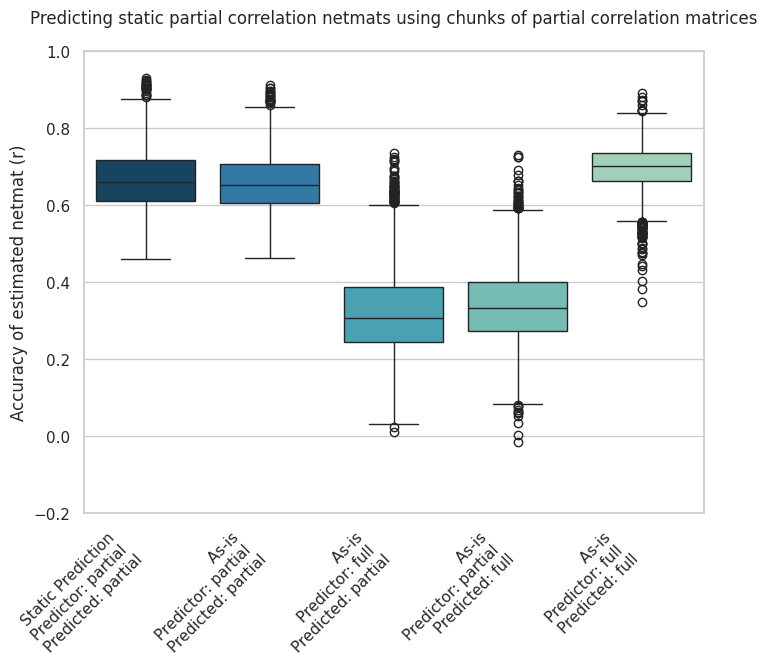

In [63]:
##################### Plot box plots of accuracies across HMM feature groups (across edges)  ########################

# transform array to list to make dataframe to pot as boxplots across edges
hmm_features_accuracy_list = []

for j in range(n_feat_type):
    hmm_features_accuracy_list.append(hmm_features_accuracy[j,:,:].flatten())

print(len(hmm_features_accuracy_list))
print(hmm_features_accuracy_list[0].shape)


# Create a dataframe with the data and group names
df = pd.DataFrame({'Group': np.repeat(labels, [hmm_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
                   'Value': np.concatenate(hmm_features_accuracy_list)})

# Create the grouped boxplot using Seaborn
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd', '#9ad6b8', '#c8e9b3', '#e1f5ca']
#colors = ['#0B486B', '#6bc6bd']
sns.set(style="whitegrid")
#sns.set(style="white")
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('')
plt.ylabel('Accuracy of estimated netmat (r)')

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ymin = -0.2  # Minimum y-value
ymax = 1  # Maximum y-value
ax.set_ylim(ymin, ymax)


# Set the title
plt.title("Predicting static partial correlation netmats using chunks of partial correlation matrices", fontsize=12, pad=20)

# Show the plot
plt.show()

In [64]:
# now load ???
static_dir = f"{proj_dir}/results/ICA_{n_ICs}/static"
partial_correlations_chunk = np.load(f"{static_dir}/partial_correlations_{n_chunk}_chunks.npy")
print(partial_correlations_chunk.shape)
partial_correlations_chunk_flatten = PartialCorrClass.extract_upper_off_main_diag(partial_correlations_chunk)
print(partial_correlations_chunk_flatten.shape)

predicted_edges_static = feature_prediction_dict['static_icov_icov']['predict_y']
print(partial_correlations_chunk_flatten.shape)
static_chunk_actual_flatten_mean = np.mean(partial_correlations_chunk_flatten, axis=0)
print(static_chunk_actual_flatten_mean.shape)
print(predicted_edges_static.shape)
predicted_edges_static_mean = np.mean(predicted_edges_static, axis=1)
print(predicted_edges_static_mean.shape)

print(ground_truth_icov_reshape_mean.shape)
ground_truth_icov_reshape_mean = ground_truth_icov_reshape_mean[0:n_edge]
print(ground_truth_icov_reshape_mean.shape)
print(static_chunk_actual_flatten_mean.shape)
static_chunk_actual_flatten_mean = static_chunk_actual_flatten_mean[:,0:n_edge]
print(static_chunk_actual_flatten_mean.shape)

(1003, 4, 50, 50)
(1003, 4, 1225)
(1003, 4, 1225)
(4, 1225)
(4, 1003, 1225)
(4, 1225)
(1225,)
(1225,)
(4, 1225)
(4, 1225)


In [65]:
predicted_edges_static_mean.shape

(4, 1225)

In [66]:
df_combined_mse_chunk_1 = df_combined_mse.loc[df_combined_mse['Group'] == 1]
print(df_combined_mse_chunk_1)
df_combined_mse_chunk_1_static = df_combined_mse_chunk_1.loc[df_combined_mse_chunk_1['Dataset'] == 'Static (prediction)']
print(df_combined_mse_chunk_1_static)

df_combined_mse_chunk_1_actual = df_combined_mse_chunk_1.loc[df_combined_mse_chunk_1['Dataset'] == 'Static (as-is)']
print(df_combined_mse_chunk_1_actual)

      Group       MSE              Dataset
0         1  1.401997       Static (as-is)
1         1  1.220349       Static (as-is)
2         1  0.929090       Static (as-is)
3         1  0.546842       Static (as-is)
4         1  0.455301       Static (as-is)
...     ...       ...                  ...
6120      1  0.075077  Static (prediction)
6121      1  0.073110  Static (prediction)
6122      1  0.080597  Static (prediction)
6123      1  0.070373  Static (prediction)
6124      1  0.065017  Static (prediction)

[2450 rows x 3 columns]
      Group       MSE              Dataset
4900      1  0.843838  Static (prediction)
4901      1  0.685323  Static (prediction)
4902      1  0.480331  Static (prediction)
4903      1  0.193089  Static (prediction)
4904      1  0.211880  Static (prediction)
...     ...       ...                  ...
6120      1  0.075077  Static (prediction)
6121      1  0.073110  Static (prediction)
6122      1  0.080597  Static (prediction)
6123      1  0.070373  Static

In [67]:
#df_combined_mse_chunk_1_actual.get(MSE)



In [68]:
print(df_combined_mse_chunk_1_static["MSE"].shape)

print(df_combined_mse_chunk_1_actual["MSE"].shape)



(1225,)
(1225,)


In [69]:
df_combined_mse_chunk_1_static["MSE"]

4900    0.843838
4901    0.685323
4902    0.480331
4903    0.193089
4904    0.211880
          ...   
6120    0.075077
6121    0.073110
6122    0.080597
6123    0.070373
6124    0.065017
Name: MSE, Length: 1225, dtype: float64

In [70]:
# find the difference between the prediction and the ground truth for both the 'prediction' and 'actual' version

# static_prediction_MSE = df_combined_mse_chunk_1_static["MSE"]#.tolist() #(predicted_edges_static_mean[1,:] - ground_truth_icov_reshape_mean)**2
# static_actual_MSE = df_combined_mse_chunk_1_actual["MSE"]#.tolist() #(static_chunk_actual_flatten_mean[1,:] - ground_truth_icov_reshape_mean)**2
# #static_prediction_ASE = np.abs((predicted_edges_static_mean[1,:] - ground_truth_icov_reshape_mean))
# #static_actual_ASE = np.abs((static_chunk_actual_flatten_mean[1,:] - ground_truth_icov_reshape_mean))

# # find the difference between the 'prediction' MSE and the 'actual' MSE
# prediction_actual_MSE_diff = df_combined_mse_chunk_1_actual["MSE"] - df_combined_mse_chunk_1_static["MSE"]  #(static_actual_MSE - static_prediction_MSE)
# #prediction_actual_ASE_diff = (static_actual_ASE - static_prediction_ASE)

# Extract the values from the Series objects
static_prediction_MSE = df_combined_mse_chunk_1_static["MSE"].values
static_actual_MSE = df_combined_mse_chunk_1_actual["MSE"].values

# Perform element-wise subtraction
prediction_actual_MSE_diff = static_actual_MSE - static_prediction_MSE

#print(predicted_edges_static_mean.shape)
print(static_chunk_actual_flatten_mean.shape)
print(np.nansum(static_prediction_MSE)) # prediction is MUCH better than the 'actual'
print(np.nansum(static_actual_MSE))

# turn into a 25 x 25 matrix in order to plot more nicely
MSEs_array = np.zeros((3, n_ICs, n_ICs))
m, n = np.triu_indices(n_ICs, 1)
MSEs_array[0, m, n] = static_actual_MSE 
MSEs_array[0, n, m] = static_actual_MSE 
MSEs_array[1, m, n] = static_prediction_MSE 
MSEs_array[1, n, m] = static_prediction_MSE 
MSEs_array[2, m, n] = prediction_actual_MSE_diff 
MSEs_array[2, n, m] = prediction_actual_MSE_diff 

# ASEs_array = np.zeros((3, n_ICs, n_ICs))
# m, n = np.triu_indices(n_ICs, 1)
# ASEs_array[0, m, n] = static_actual_ASE 
# ASEs_array[0, n, m] = static_actual_ASE 
# ASEs_array[1, m, n] = static_prediction_ASE 
# ASEs_array[1, n, m] = static_prediction_ASE 
# ASEs_array[2, m, n] = prediction_actual_ASE_diff 
# ASEs_array[2, n, m] = prediction_actual_ASE_diff 

(4, 1225)
323.0972893829845
720.0418105902828


In [71]:
# Define the brain networks
if n_ICs == 25:
    brain_networks = ['VIS', 'VIS', 'VIS', 'DM', 'FP', 'VAT', 'DM', 'DM', 'VIS', 'FP',
                    'FP', 'ATT', 'SSM', 'VIS', 'AUD', 'DAT', 'EC', 'ATT', 'DM',
                    'EC', 'SSM', 'CB', 'SN', 'THAL', 'BG']
elif n_ICs == 50:
    brain_networks = ['VIS', 'VIS', 'VIS', 'DM', 'FP', 'VAT', 'DM', 'DM', 'VIS', 'FP',
                    'FP', 'ATT', 'SSM', 'VIS', 'AUD', 'DAT', 'EC', 'ATT', 'DM',
                    'EC', 'SSM', 'CB', 'SN', 'THAL', 'BG',
                    'VIS', 'VIS', 'VIS', 'DM', 'FP', 'VAT', 'DM', 'DM', 'VIS', 'FP',
                    'FP', 'ATT', 'SSM', 'VIS', 'AUD', 'DAT', 'EC', 'ATT', 'DM',
                    'EC', 'SSM', 'CB', 'SN', 'THAL', 'BG']


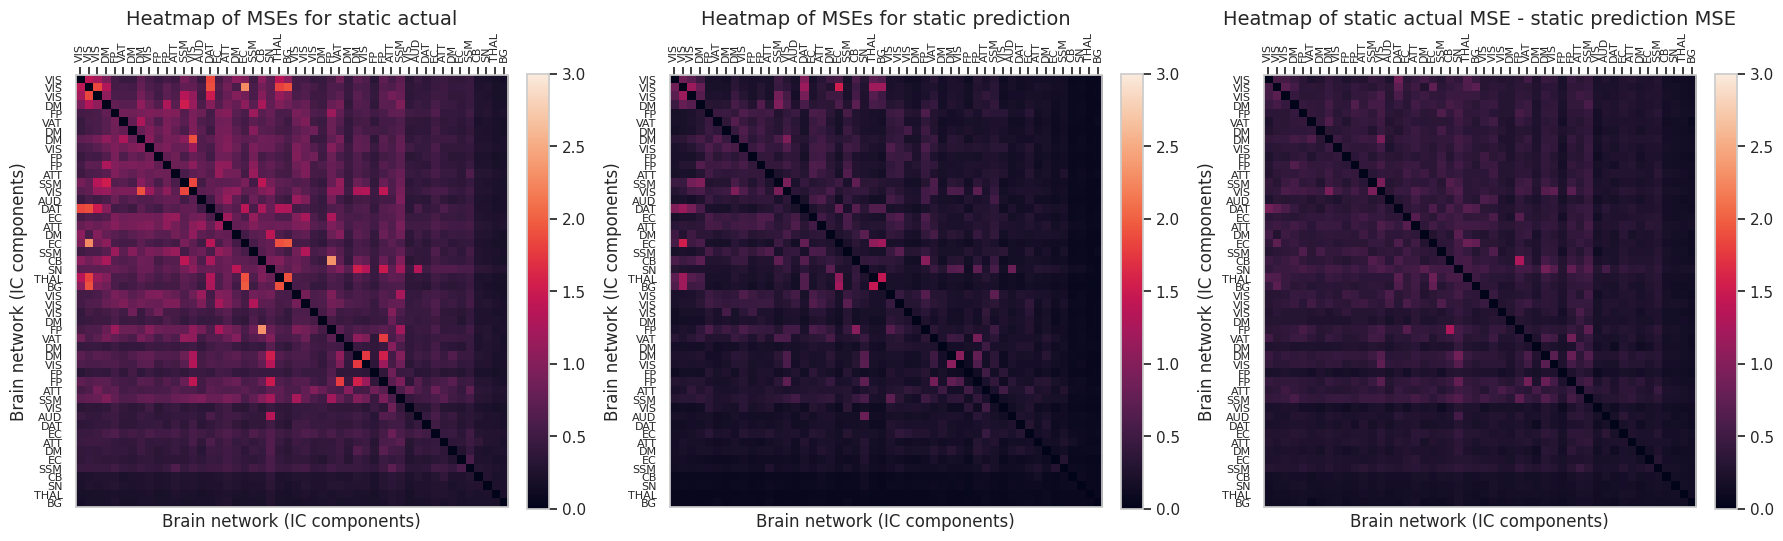

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

titles = [
    "Heatmap of MSEs for static actual",
    "Heatmap of MSEs for static prediction",
    "Heatmap of static actual MSE - static prediction MSE"
]

for i in range(3):
    # Create the heatmap
    heatmap = axs[i].imshow(MSEs_array[i,:,:], vmin = 0,  cmap='rocket', vmax = 3)

    # Remove the grey grid lines
    axs[i].grid(False)

    # Add a colorbar
    cbar = fig.colorbar(heatmap, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)

    # Set the x-axis and y-axis labels as "Brain networks"
    axs[i].set_xlabel("Brain network (IC components)", fontsize=12)
    axs[i].set_ylabel("Brain network (IC components)", fontsize=12)

    # Set the x-axis and y-axis tick positions and labels
    axs[i].set_xticks(range(n_ICs))
    axs[i].set_yticks(range(n_ICs))
    axs[i].set_xticklabels(brain_networks, fontsize=8, rotation=90)
    axs[i].set_yticklabels(brain_networks, fontsize=8)

    # Move the x-axis tick labels to the top
    axs[i].xaxis.set_ticks_position('top')

    # Set the title
    axs[i].set_title(titles[i], fontsize=14)

# Adjust layout to make room for the colorbars
plt.tight_layout()
plt.show()

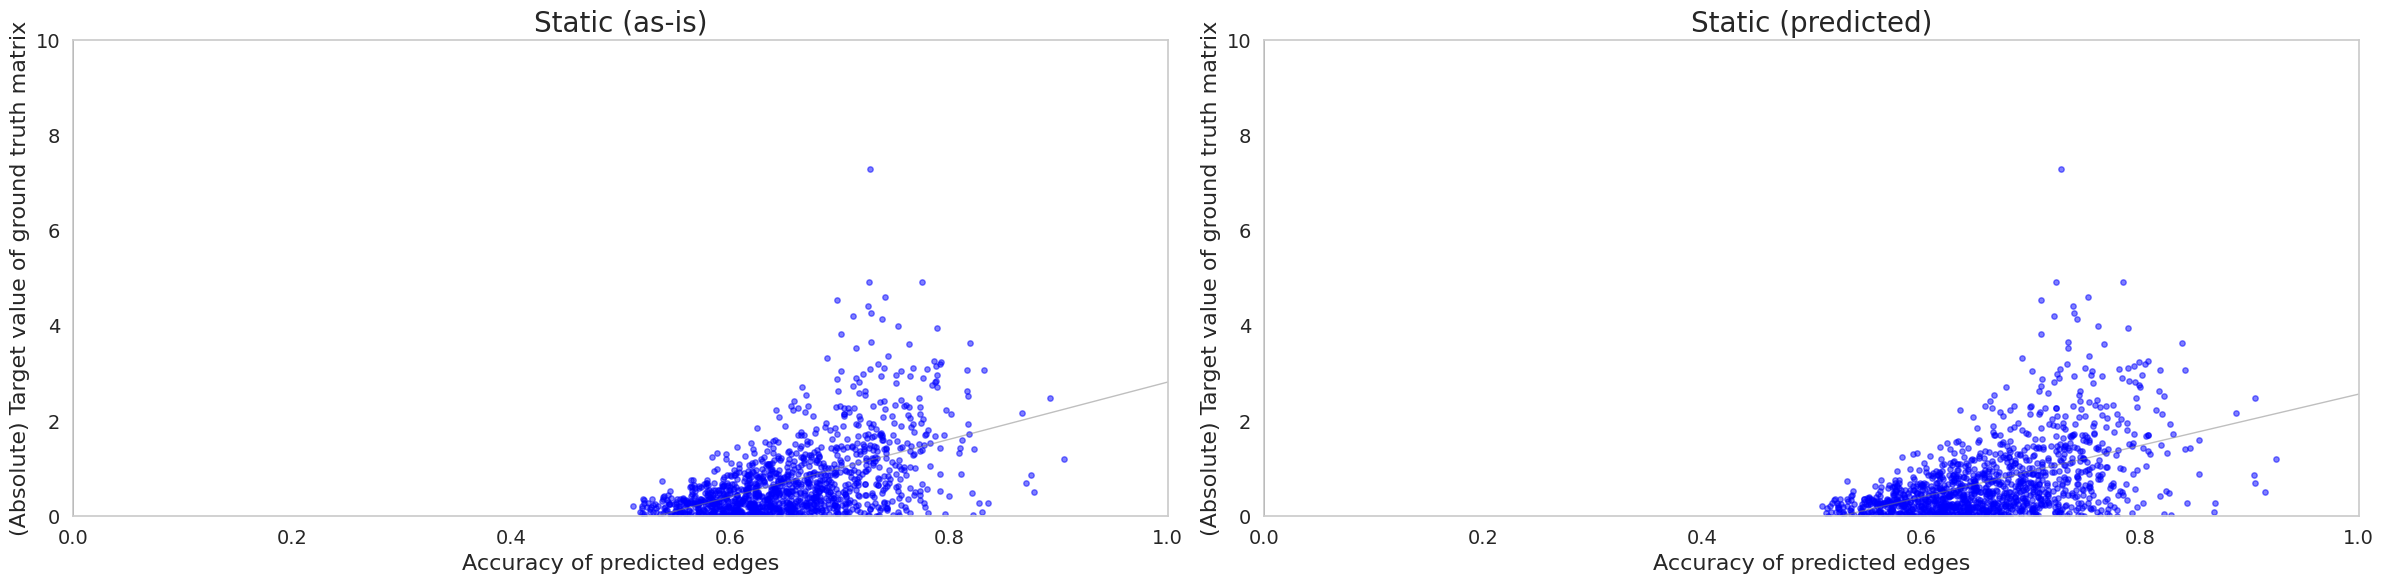

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming feature_prediction_dict and ground_truth_icov_reshape_mean are already defined

# Define the different x datasets
x_actual = np.mean(feature_prediction_dict['actual_icov_icov']['accuracy_per_edge'], axis=0)
x_static = np.mean(feature_prediction_dict['static_icov_icov']['accuracy_per_edge'], axis=0)
#x_fc = np.mean(feature_prediction_dict['fc']['accuracy_per_edge'], axis=0)

y = np.abs(ground_truth_icov_reshape_mean)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))  # 1 row, 3 columns

# List of x datasets and titles for each subplot
x_data = [x_actual, x_static]  # , x_fc]
titles = ['Static (as-is)', 'Static (predicted)']  # , 'FC']

for ax, x, title in zip(axes, x_data, titles):
    # Create the scatter plot
    ax.scatter(x, y, color='blue', alpha=0.5, s=15)  # Set the color and transparency

    # Add black lines on x and y axes
    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line at x=0

    # Set plot title and labels
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Accuracy of predicted edges', fontsize=16)
    ax.set_ylabel('(Absolute) Target value of ground truth matrix', fontsize=16)

    # Set axes limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 10])

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Hide the grid
    ax.grid(False)

    # Fit linear regression via least squares with numpy.polyfit
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 10
    xseq = np.linspace(0, 10, num=100)

    #ax.axvline(x=0.6, color='black', linestyle='-', linewidth=3)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color="grey", lw=1, alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


dict_keys(['static_icov_icov', 'actual_icov_icov', 'actual_icov_cov', 'actual_cov_icov', 'actual_cov_cov'])
(4, 1225)
(4, 1225)
(3, 50, 50)
(3, 1225)
(1225,)


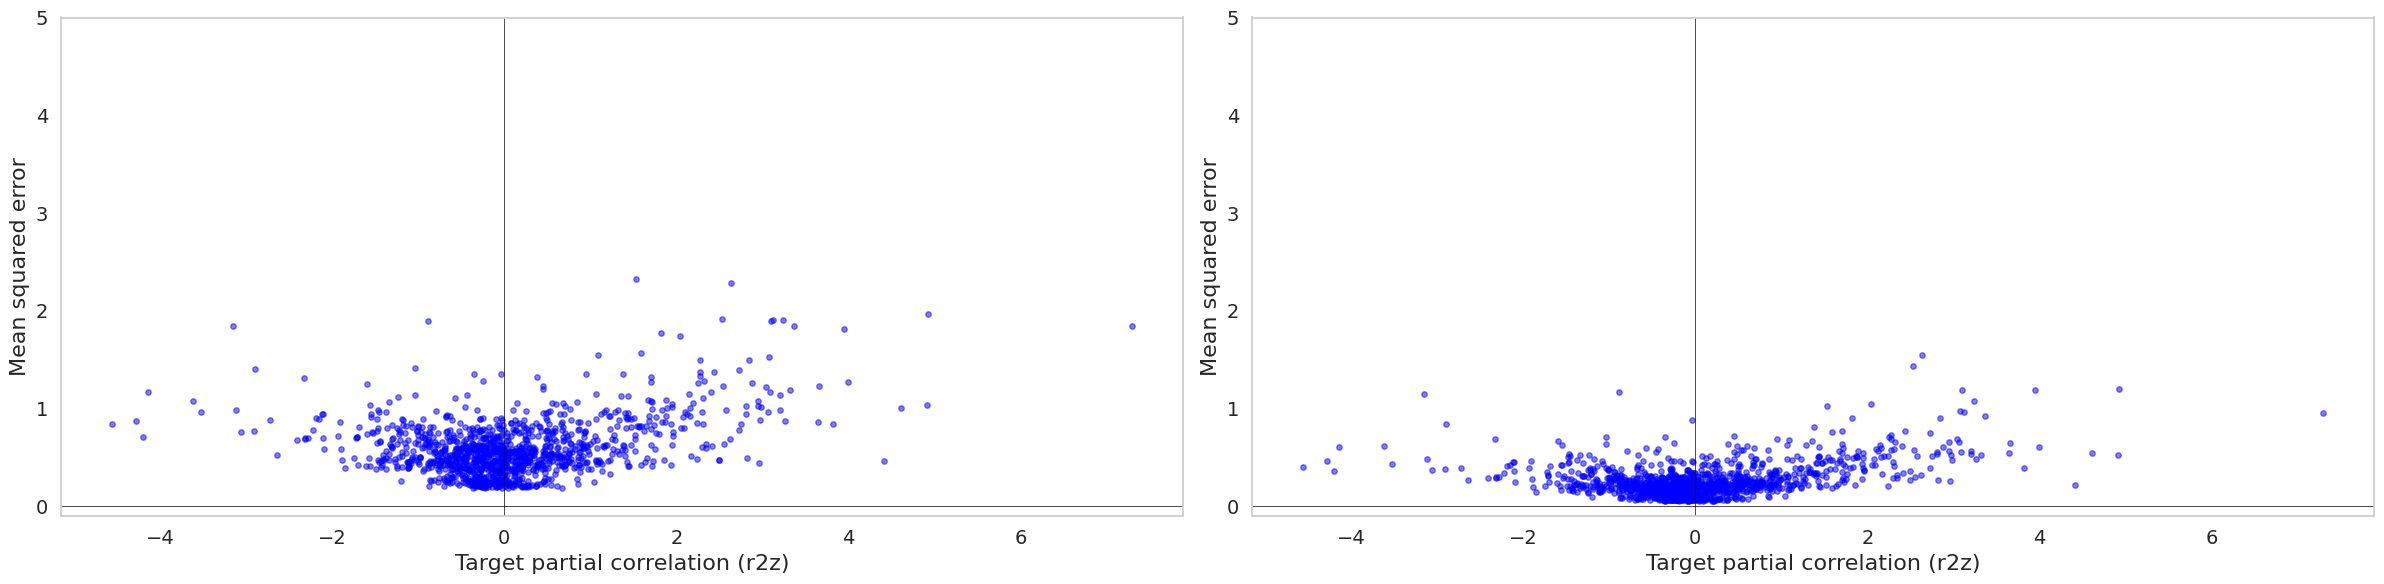

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming MSEs_array_reshape and ground_truth_icov_reshape_mean are defined as in your code
print(feature_prediction_dict.keys())
print(feature_prediction_dict['static_icov_icov']['accuracy_per_edge'].shape)
print(feature_prediction_dict['actual_icov_icov']['accuracy_per_edge'].shape)
print(MSEs_array.shape)
MSEs_array_reshape = MSEs_array[..., m, n]  # flatten covs
#ASEs_array_reshape = ASEs_array[..., m, n]  # flatten covs
print(MSEs_array_reshape.shape)
print(ground_truth_icov_reshape_mean.shape)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))  # 1 row, 2 columns

for j in range(2):
    x = ground_truth_icov_reshape_mean
    y = MSEs_array_reshape[j, :]

    # Create the scatter plot in the j-th subplot
    ax = axes[j]
    ax.scatter(x, y, color='blue', alpha=0.5, s=15)  # Set the color and transparency

    # Add black lines on x and y axes
    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line at x=0

    # Set plot title and labels with increased font size
    #ax.set_title(f"Plot {j + 1} Title", fontsize=20)  # Replace with appropriate title
    ax.set_xlabel('Target partial correlation (r2z)', fontsize=16)
    ax.set_ylabel('Mean squared error', fontsize=16)
    
    # Set the y-axis limits
    ax.set_ylim(-0.1, 5)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Hide the grid
    ax.grid(False)

# Show the figure
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


In [75]:
print(static_chunk_actual_flatten_mean.shape)
print(predicted_edges_static_mean.shape)
#print(predicted_edges_fc_mean.shape)

(4, 1225)
(4, 1225)


(4, 10, 1225, 1225)
(1225,)


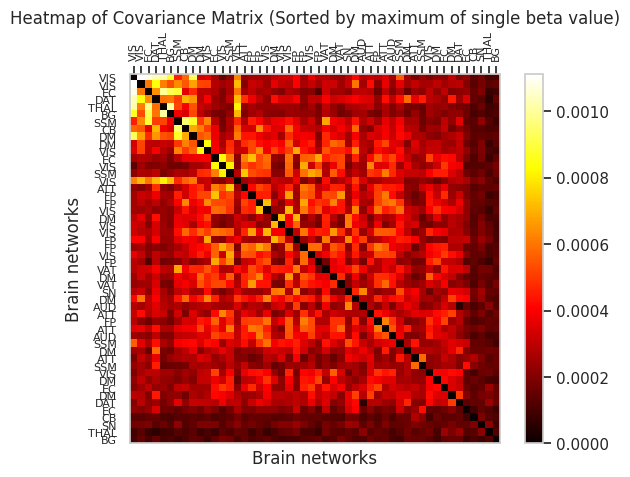

In [76]:
################### Heatmap of betas for static predictions ###################

# note betas then reshape for plot
betas_static = feature_prediction_dict['static_icov_icov']['beta']
print(betas_static.shape)
betas_static_mean = np.mean(np.mean(np.mean(betas_static, axis = 0), axis = 0), axis = 0)
print(betas_static_mean.shape)
betas_static_mean_reshape = np.zeros((n_ICs, n_ICs))
m, n = np.triu_indices(n_ICs, 1)
betas_static_mean_reshape[m, n] = betas_static_mean
betas_static_mean_reshape[n, m] = betas_static_mean

# Calculate the maximum values of each row
row_max_values = np.max(betas_static_mean_reshape, axis=1)

# Get the sorting indices based on the maximum values
sorting_indices = np.argsort(row_max_values)[::-1]

# Reorder the covariance matrix and brain networks based on the sorting indices
betas_static_mean_reshape_sorted = betas_static_mean_reshape[sorting_indices][:, sorting_indices]
brain_networks_sorted = [brain_networks[i] for i in sorting_indices]

# Create a new figure
fig, ax = plt.subplots()

# Create the heatmap
heatmap = ax.imshow(betas_static_mean_reshape_sorted, cmap='hot')

# Remove the grey grid lines
ax.grid(False)

# Add a colorbar
cbar = plt.colorbar(heatmap)

# Set the x-axis and y-axis labels as "Brain networks"
ax.set_xlabel("Brain networks", fontsize=12)
ax.set_ylabel("Brain networks", fontsize=12)

# Set the x-axis and y-axis tick positions and labels
ax.set_xticks(range(n_ICs))
ax.set_yticks(range(n_ICs))
ax.set_xticklabels(brain_networks_sorted, fontsize=8, rotation=90)
ax.set_yticklabels(brain_networks_sorted, fontsize=8)

# Move the x-axis tick labels to the top
ax.xaxis.set_ticks_position('top')

# Set the title
plt.title("Heatmap of Covariance Matrix (Sorted by maximum of single beta value)")

# Show the figure
plt.show()

In [77]:
# # interleave columns of data and then remove NaNs
accuracy_per_edge = predicted_edges_static_mean
accuracy_per_edge_actual_1 = static_chunk_actual_flatten_mean


row_a, col_a = np.shape(accuracy_per_edge_actual_1)
row_b, col_b = np.shape(accuracy_per_edge)
accuracy_interleave = np.ravel([accuracy_per_edge_actual_1, accuracy_per_edge],order="F").reshape(col_a,row_a+row_b).T
print(accuracy_interleave.shape)
accuracy_interleave_clean = accuracy_interleave[:, ~np.isnan(accuracy_interleave).any(axis=0)]
print(accuracy_interleave_clean.shape)

(8, 1225)
(8, 1225)


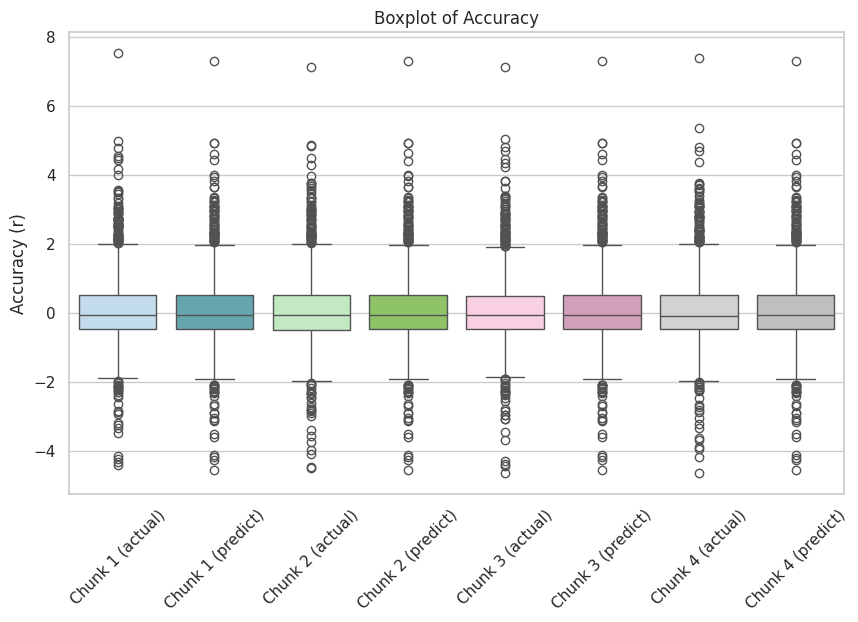

In [78]:
# Assuming you have accuracy_interleave defined

# Create labels for the boxplot
if n_chunk == 4:
    labels = ['Chunk 1 (actual)','Chunk 1 (predict)','Chunk 2 (actual)','Chunk 2 (predict)','Chunk 3 (actual)','Chunk 3 (predict)','Chunk 4 (actual)','Chunk 4 (predict)']
elif n_chunk == 12:
    labels = ['Chunk 1 (actual)','Chunk 1 (predict)','Chunk 2 (actual)','Chunk 2 (predict)','Chunk 3 (actual)','Chunk 3 (predict)','Chunk 4 (actual)','Chunk 4 (predict)',
                'Chunk 5 (actual)','Chunk 5 (predict)','Chunk 6 (actual)','Chunk 6 (predict)','Chunk 7 (actual)','Chunk 7 (predict)','Chunk 8 (actual)','Chunk 8 (predict)',
                'Chunk 9 (actual)','Chunk 9 (predict)','Chunk 10 (actual)','Chunk 10 (predict)','Chunk 11 (actual)','Chunk 11 (predict)','Chunk 12 (actual)','Chunk 12 (predict)']

# Define custom colors for the boxplot using RGBA tuples
colors = [(0.737, 0.867, 0.949), (0.349, 0.686, 0.725), (0.737, 0.937, 0.737), (0.549, 0.824, 0.349), (1, 0.788, 0.882), (0.859, 0.596, 0.729), (0.824, 0.824, 0.824), (0.749, 0.749, 0.749)]


# Create the boxplot with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=accuracy_interleave_clean.T, palette=colors)

# Set plot title and labels
plt.title('Boxplot of Accuracy')
plt.ylabel('Accuracy (r)')

# Rotate x-axis labels by 45 degrees
plt.xticks(range(len(labels)), labels, rotation=45)

# Show the plot
plt.show()



In [79]:
# prepare betas for plot
betas_static = feature_prediction_dict['static_icov_icov']['beta']
print(betas_static.shape)
betas_static_mean = np.mean(betas_static, axis = 1)
print(betas_static_mean.shape)

static_betas_mean_self_predict = np.zeros((n_chunk, n_edge))
for chunk in range(n_chunk):
    static_betas_mean_self_predict[chunk,:] = np.diag(betas_static_mean[chunk,:,:])


mask = ~np.eye(betas_static_mean.shape[1], dtype=bool)

non_diagonal_elements = np.zeros((n_chunk, n_edge*n_edge - n_edge))

# Use the mask to extract non-diagonal elements
for chunk in range(n_chunk):
    non_diagonal_elements[chunk,:] = betas_static_mean[chunk,mask]

print(static_betas_mean_self_predict.shape)
print(non_diagonal_elements.shape)

(4, 10, 1225, 1225)
(4, 1225, 1225)
(4, 1225)
(4, 1499400)


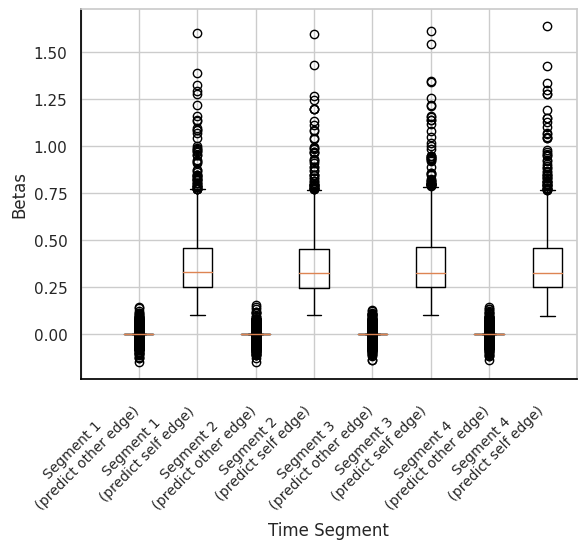

In [80]:
# Create an empty list to store the combined data for plotting
combined_data = []

# Iterate over each row in 'non_diagonal_elements' and corresponding row in 'static_betas_mean_self_predict'
for i in range(n_chunk):
    # Add the first 105300 values from 'non_diagonal_elements'
    non_diagonal_elements_clean = non_diagonal_elements[i][~np.isnan(non_diagonal_elements[i])]
    combined_data.append(non_diagonal_elements_clean)
    # Add the corresponding row from 'static_betas_mean_self_predict'
    static_betas_mean_self_predict_clean = static_betas_mean_self_predict[i][~np.isnan(static_betas_mean_self_predict[i])]
    combined_data.append(static_betas_mean_self_predict_clean)

# Create a boxplot

plt.boxplot(combined_data)

# Set labels for x-axis ticks
if n_chunk == 4:
    labels = ['Segment 1 \n (predict other edge)', 'Segment 1 \n  (predict self edge)', 'Segment 2 \n (predict other edge)', 'Segment 2 \n (predict self edge)', 
                                'Segment 3 \n (predict other edge)', 'Segment 3 \n (predict self edge)', 'Segment 4 \n (predict other edge)', 'Segment 4 \n (predict self edge)']
elif n_chunk == 12:
    labels = ['1 (other)', '1 (self)', '2 (other)', '2 (self)', 
              '3 (other)', '3 (self)', '4 (other)', '4 (self)',
              '5 (other)', '5 (self)', '6 (other)', '6 (self)', 
              '7 (other)', '7 (self)', '8 (other)', '8 (self)',
              '9 (other)', '9 (self)', '10 (other)', '10 (self)', 
              '11 (other)', '11 (self)', '12 (other)', '12 (self)']

plt.xticks(np.arange(1, 2*n_chunk+1)-1, labels, fontsize=10)

plt.xticks(rotation=45)

# Set labels for y-axis and title
plt.ylabel('Betas')
plt.xlabel('Time Segment')
#plt.title('Boxplot of Non-Diagonal Elements and Static Betas')

# Set the color of the spines to black
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

# Show the plot
plt.show()